# Retrieving data on BART ridership

In [22]:
from pybart.api import BART # for interacting w/ BART API
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from postgres_login import secret # my postgreSQL password
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import os
import sys
import io
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# import custom scripts
import pitt_line_stations

## Set up data base
If we haven't already, set up the postgres database that will house the data

In [6]:
# Define a database name 
dbname = 'bart_db'
username = 'bkhurley' # change this to your username

In [7]:
# db connection
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://bkhurley@localhost/bart_db


In [8]:
# create the database if it doesn't exist
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


## Get the data 
Retrieve the BART data and store it in the 'bart_db' database

#### Define some functions

In [9]:
# load and append the data into a pandas dataframe
def load_bart_orig_dest_data(urls):
    # generate list of dataframes from the provided csv urls
    data_ls = [pd.read_csv(d, header=None) for d in urls]
    # return single concatinated dataframe
    data = pd.concat(data_ls)
    return data    

#### Retrieve BART data

In [10]:
# the data come from CSVs provided on the web yearly by BART
orig_dest_urls = ['http://64.111.127.166/origin-destination/date-hour-soo-dest-2011.csv.gz',
       'http://64.111.127.166/origin-destination/date-hour-soo-dest-2012.csv.gz',
       'http://64.111.127.166/origin-destination/date-hour-soo-dest-2013.csv.gz',
       'http://64.111.127.166/origin-destination/date-hour-soo-dest-2014.csv.gz',
       'http://64.111.127.166/origin-destination/date-hour-soo-dest-2015.csv.gz',
       'http://64.111.127.166/origin-destination/date-hour-soo-dest-2016.csv.gz',
       'http://64.111.127.166/origin-destination/date-hour-soo-dest-2017.csv.gz']

In [11]:
# get the data and put them into a dataframe
bart_dest_org_df = load_bart_orig_dest_data(orig_dest_urls)

In [12]:
# check out the structure of the raw data
bart_dest_org_df.head()

,0,1,2,3,4
0,2011-01-01,0,12TH,12TH,1
1,2011-01-01,0,12TH,16TH,1
2,2011-01-01,0,12TH,24TH,3
3,2011-01-01,0,12TH,ASHB,2
4,2011-01-01,0,12TH,BAYF,5


### Initial cleaning

In [13]:
# rename columns to something informative
bart_dest_org_df.rename(columns={0: 'date', 1: 'hour', 2: 'orig', 3: 'dest', 4: 'trips_per_hr'},
         inplace=True)

In [14]:
bart_dest_org_df.head()

,date,hour,orig,dest,trips_per_hr
0,2011-01-01,0,12TH,12TH,1
1,2011-01-01,0,12TH,16TH,1
2,2011-01-01,0,12TH,24TH,3
3,2011-01-01,0,12TH,ASHB,2
4,2011-01-01,0,12TH,BAYF,5


### Get route info 

For now, let's just look at trips originating from or terminating at stations on the PITT line. This is the busiest BART line.

Can get ordered list of stations on the PITT line from the BART's [route info API](https://api.bart.gov/docs/route/routeinfo.aspx)

In [35]:
# access BART API w/ public key
bart = BART(json_format=True)

In [46]:
# request ordered station names for the PITT-MLBR route
route_info_root = bart.route.routeinfo(route=1)
stations = route_info_root['routes']['route']['config']['station']
print(stations)

['PITT', 'NCON', 'CONC', 'PHIL', 'WCRK', 'LAFY', 'ORIN', 'ROCK', 'MCAR', '19TH', '12TH', 'WOAK', 'EMBR', 'MONT', 'POWL', 'CIVC', '16TH', '24TH', 'GLEN', 'BALB', 'DALY', 'COLM', 'SSAN', 'SBRN', 'SFIA', 'MLBR']


#### Use the above station list to filter for trips that start and end on the PITT line

In [76]:
pitt_df = bart_dest_org_df.loc[bart_dest_org_df['orig'].isin(stations) &
                               bart_dest_org_df['dest'].isin(stations)]
# Some trips originate and terminate at the same station. 
# Going to remove for now until I figure out what's going on.
pitt_df.drop(pitt_df[pitt_df['orig'] == pitt_df['dest']].index, inplace=True)
pitt_df.reset_index(drop=True, inplace=True) # renumber indices after dropping rows

#### Differentiate northbound from southbound

In [192]:
def get_route_dir(df, stations):
    '''
    Use the ordered list of stations on the PITT line to determine direction 
    '''
    for station in stations:
        station_idx = stations.index(station)
        # label southbound trips, unless already at end of line
        if not station == 'MLBR':
            sb_stations = stations[(station_idx+1):]
            df.loc[((df['orig'] == station) & 
                    df['dest'].isin(sb_stations)), 'direction'] = 'southbound'
        # label northbound trips, unless at beginning of line
        if not station == 'PITT':
            nb_stations = stations[:(station_idx)]
            df.loc[((df['orig'] == station) &
                    df['dest'].isin(nb_stations)), 'direction'] = 'northbound'
    return df

In [193]:
# determine & label nbound/sbound direction of trips
pitt_df['direction'] = '' # initialize column
pitt_df = get_route_dir(pitt_df, stations)

Check that the direction labels are correct

In [195]:
pitt_df.loc[pitt_df['direction'] == 'northbound'].head()

,date,hour,orig,dest,trips_per_hr,direction
2,2011-01-01,0,12TH,CONC,2,northbound
5,2011-01-01,0,12TH,MCAR,12,northbound
8,2011-01-01,0,12TH,PHIL,1,northbound
9,2011-01-01,0,12TH,PITT,1,northbound
11,2011-01-01,0,16TH,12TH,5,northbound


In [196]:
pitt_df.loc[pitt_df['direction'] == 'southbound'].head()

,date,hour,orig,dest,trips_per_hr,direction
0,2011-01-01,0,12TH,24TH,3,southbound
1,2011-01-01,0,12TH,CIVC,3,southbound
3,2011-01-01,0,12TH,DALY,1,southbound
4,2011-01-01,0,12TH,EMBR,4,southbound
6,2011-01-01,0,12TH,MLBR,1,southbound


### Calculate rider volume 

In [197]:
# get a subset for testing
test_data = pitt_df.loc[(pitt_df['direction'] == 'southbound') &
                       (pitt_df['date'] == '2011-01-01') &
                       (pitt_df['hour'] == 8) &
                       (pitt_df['orig'] == 'NCON')]

In [ ]:
# aggregate number of entries and exits at this location for this time


#### Generate some temporal features from the date

In [18]:
# transform the dates to pd datetime objects
df_pitt['date'] = pd.to_datetime(df_pitt['date'])

In [19]:
# generate weekday and month features
df_pitt['day'] = df_pitt['date'].dt.weekday_name
df_pitt['month'] = df_pitt['date'].dt.month

In [20]:
df_pitt.head(10)

,date,hour,orig,dest,trips_per_hr,day,month
0,2011-01-01,0,12TH,12TH,1,Saturday,1
1,2011-01-01,0,12TH,16TH,1,Saturday,1
2,2011-01-01,0,12TH,24TH,3,Saturday,1
3,2011-01-01,0,12TH,ASHB,2,Saturday,1
4,2011-01-01,0,12TH,BAYF,5,Saturday,1
5,2011-01-01,0,12TH,CIVC,3,Saturday,1
6,2011-01-01,0,12TH,COLS,1,Saturday,1
7,2011-01-01,0,12TH,CONC,2,Saturday,1
8,2011-01-01,0,12TH,DALY,1,Saturday,1
9,2011-01-01,0,12TH,DBRK,4,Saturday,1


### Insert BART trip data into database

In [31]:
#conn = engine.raw_connection()
# connect to postgres
conn = psycopg2.connect(database='bart_db', user='postgres', password=secret)
# retrieve the cursor
cur = conn.cursor()

In [ ]:
f = io.StringIO()
df_pitt.to_csv(f, index=False, header=False)  # removed header
f.seek(0)  # move position to beginning of file before reading
cursor = conn.cursor()
cursor.execute(
    'CREATE TABLE IF NOT EXISTS orig_dest (date date PRIMARY KEY, hour integer, orig varchar, dest varchar, trips_per_hr integer, day varchar, month integer); COMMIT; '
)
cursor.copy_from(f, 'orig_dest', columns=(
    'date', 'hour', 'orig', 'dest', 'trips_per_hr', 'day', 'month'), 
                 sep=',')
cursor.execute("SELECT * FROM orig_dest;")
a = cursor.fetchall()
print(a)
cursor.close()

In [30]:
cursor.close()

In [ ]:
## insert data into database in chunks
#size = 100000
#for i in round(len(df_pitt['trips_per_hr'])/size):
#   
#df_pitt.to_sql('orig_dest', engine, if_exists='replace')

## Scrape weather data covering the relevant time

### Check out some basic visualizations
Let's narrow down to just one station from 2016 for these rough plots so we're not plotting so much data.

In [78]:
# filter for the Mcarthur station
df_mcar = df_pitt.loc[df_pitt['orig']=='MCAR', :]

In [117]:
# sum by orig station by hour, day, month
mcar_sum = df_mcar.groupby(by=['orig', 'day', 'hour']).sum()['trips_per_hr']
mcar_sum.fillna(value=0, inplace=True)

In [118]:
mcar_sum.head(30)

orig  day     hour
MCAR  Friday  0        2425
              1         525
              2          86
              3          46
              4         673
              5        4407
              6       13453
              7       36015
              8       66494
              9       54544
              10      28817
              11      19580
              12      18238
              13      17435
              14      17129
              15      21886
              16      32206
              17      43262
              18      38040
              19      22395
              20      12505
              21       9957
              22       8098
              23       6256
      Monday  0        1502
              1         344
              3           1
              4         603
              5        4124
              6       13689
Name: trips_per_hr, dtype: int64

In [115]:
mcar_sum.head(30)

hour                0      1     2     3      4       5        6        7   \
orig day                                                                     
MCAR Friday     2425.0  525.0  86.0  46.0  673.0  4407.0  13453.0  36015.0   
     Monday     1502.0  344.0   0.0   1.0  603.0  4124.0  13689.0  36227.0   
     Saturday   4008.0  963.0   0.0   0.0    0.0     5.0   2502.0   5237.0   
     Sunday     3477.0  925.0   0.0   0.0    0.0     0.0     45.0    238.0   
     Thursday   2212.0  430.0   0.0   1.0  721.0  4801.0  15217.0  41145.0   
     Tuesday    1934.0  409.0   0.0   0.0  794.0  4825.0  15819.0  43627.0   
     Wednesday  2201.0  479.0   1.0   0.0  850.0  5042.0  15597.0  42513.0   

hour                 8        9    ...         14       15       16       17  \
orig day                           ...                                         
MCAR Friday     66494.0  54544.0   ...    17129.0  21886.0  32206.0  43262.0   
     Monday     68651.0  56588.0   ...    13821.0  18267.0  27946.0  40979.0   
     Saturday    9163.0  13878.0   ...    16921.0  15703.0  15149.0  16289.0   
     Sunday      5676.0   9401.0   ...    13650.0  12316.0  11423.0  10732.0   
     Thursday   74496.0  61340.0   ...    15194.0  20389.0  31817.0  45541.0   
     Tuesday    78406.0  62627.0   ...    14574.0  19989.0  31420.0  45354.0   
     Wednesday  77229.0  61986.0   ...    15785.0  20663.0  31662.0  46479.0   

hour                 18       19       20      21      22      23  
orig day                                                           
MCAR Friday     38040.0  22395.0  12505.0  9957.0  8098.0  6256.0  
     Monday     36791.0  16698.0   8793.0  7526.0  5927.0  3654.0  
     Saturday   15458.0  13999.0   9932.0  8659.0  7699.0  5674.0  
     Sunday      9805.0   8586.0   6801.0  5994.0  5126.0  3285.0  
     Thursday   41569.0  21169.0  10737.0  9294.0  7494.0  4580.0  
     Tuesday    41618.0  19944.0  10235.0  8295.0  6596.0  3999.0  
     Wednesday  41538.0  19911.0  10378.0  9003.0  6781.0  4056.0  

[7 rows x 24 columns]

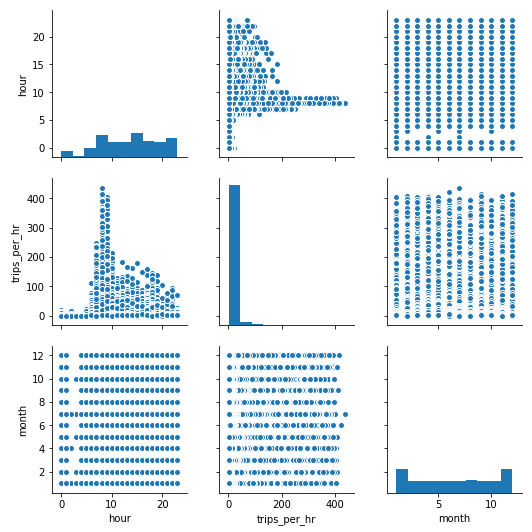

In [80]:
sns.pairplot(df_mcar)

Do some pivots to get a glimpse of temporal trends

In [119]:
day_hour_count = df_mcar.groupby(by=['day', 'hour']).sum()['trips_per_hr'].unstack()
day_hour_count.fillna(value=0, inplace=True)
#day_hour_count.head()

In [120]:
day_hour_count.head(10)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Friday,2425.0,525.0,86.0,46.0,673.0,4407.0,13453.0,36015.0,66494.0,54544.0,...,17129.0,21886.0,32206.0,43262.0,38040.0,22395.0,12505.0,9957.0,8098.0,6256.0
Monday,1502.0,344.0,0.0,1.0,603.0,4124.0,13689.0,36227.0,68651.0,56588.0,...,13821.0,18267.0,27946.0,40979.0,36791.0,16698.0,8793.0,7526.0,5927.0,3654.0
Saturday,4008.0,963.0,0.0,0.0,0.0,5.0,2502.0,5237.0,9163.0,13878.0,...,16921.0,15703.0,15149.0,16289.0,15458.0,13999.0,9932.0,8659.0,7699.0,5674.0
Sunday,3477.0,925.0,0.0,0.0,0.0,0.0,45.0,238.0,5676.0,9401.0,...,13650.0,12316.0,11423.0,10732.0,9805.0,8586.0,6801.0,5994.0,5126.0,3285.0
Thursday,2212.0,430.0,0.0,1.0,721.0,4801.0,15217.0,41145.0,74496.0,61340.0,...,15194.0,20389.0,31817.0,45541.0,41569.0,21169.0,10737.0,9294.0,7494.0,4580.0
Tuesday,1934.0,409.0,0.0,0.0,794.0,4825.0,15819.0,43627.0,78406.0,62627.0,...,14574.0,19989.0,31420.0,45354.0,41618.0,19944.0,10235.0,8295.0,6596.0,3999.0
Wednesday,2201.0,479.0,1.0,0.0,850.0,5042.0,15597.0,42513.0,77229.0,61986.0,...,15785.0,20663.0,31662.0,46479.0,41538.0,19911.0,10378.0,9003.0,6781.0,4056.0


Text(0.5,1,'Trips taken from MacArthur station')

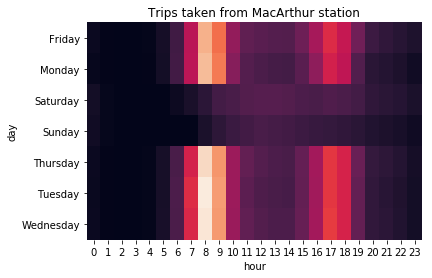

In [123]:
# plot heat map of the days and hours with most rides
sns.heatmap(day_hour_count, cbar=False)
plt.title('Trips taken from MacArthur station')